# Project 5

*Name:* Matthew Bass

Your goal is to perform a sensitivity analysis of the parameters in the fly clock model of Goldbeter.

## Instructions
<ol>
<li> Use your genetic algorithm to generate 10 excellent parameter sets (i.e. run the algorithm 10 times and use the lowest cost child from each run). You may use parameter sets you found in Project 4 or you may generate new parameter sets.
<li> For each of the parameter sets, analyze the sensitivity of the amplitude and of the period (separately) to each parameter. If at all possible, please plot the results for all parameter sets on the same graph (a box-and-whisker plot might be helpful here).
<li> What are the similarities and differences in sensitivity across parameter sets? For example, are there any parameter which make the period longer in some parameter sets, but shorter in others? Are there any parameters that have radically different sensitivities across the parameter sets?
</ol>
    
## Extensions
<ol>
<li> Analyze additional models
<li> Explore the effects of changing the size of the perturbation used to compute the sensitivities.
<li> Include an analysis of the sensitivity of state dynamics to parametric perturbation.
</ol>

## Steps to get you started

### 1. Copy-paste code and/or results from Project 4
You will need the Golbeter's model and get_period at the very least. If you are generating parameter sets in this project, you will also need the GA code and cost function. If you using parameter sets from Project 4, you can just refer to the files that have them (assuming you have .npz file).

In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

def get_period(t,x):
     """ Approximate the period of a 1-D x, given the time-steps t.
         Returns a tuple with the period and the standard deviation of
the period over time.
         if the value of the standard deviation is not smaller than 0.1,
then
         it means the period estimate is dodgy and you shouldn't use it.
Instead,
         plot your simulation and figure out why it isn't periodic -
maybe it just
         hasn't reached the limit cycle yet."""
     idxs = scipy.signal.find_peaks(x)
     idxs = idxs[0]
     times = t[idxs]
     periods = np.diff(times)
     period = periods.mean()
     sdperiod = periods.std()

     return (period,sdperiod)

# model
def gol_95(t,y,params):
    '''

    '''

    # Unpacking Params(18)
    v_s = params[0]
    v_m = params[1]
    K_m = params[2]
    k_s = params[3]
    v_d = params[4]
    k_1 = params[5]
    k_2 = params[6]
    K_I = params[7]
    K_d = params[8]
    n = params[9]
    K_1 = params[10]
    K_2 = params[11]
    K_3 = params[12]
    K_4 = params[13]
    V_1 = params[14]
    V_2 = params[15]
    V_3 = params[16]
    V_4 = params[17]

    #Unpacking Y
    M = y[0]
    P_0 = y[1]
    P_1 = y[2]
    P_2 = y[3]
    P_N = y[4]

    #Calculating the 5 differential equations
    dM_dt = v_s * K_I**n/(K_I**n + P_N**n)  -  v_m * M / (K_m + M)
    dP_0_dt = k_s * M  -  V_1*P_0/(K_1+P_0)  +  V_2 * P_1/(K_2+P_1)
    dP_1_dt =  V_1*P_0/(K_1+P_0) - V_2 * P_1/(K_2+P_1) - V_3 * P_1/(K_3+P_1) + V_4*P_2/(K_4+P_2)
    dP_2_dt = V_3 * P_1/(K_3+P_1) - V_4*P_2/(K_4+P_2) - k_1*P_2 + k_2*P_N - v_d * P_2/(K_d+P_2)
    dP_N_dt = k_1*P_2 - k_2*P_N

    return (dM_dt,dP_0_dt,dP_1_dt,dP_2_dt,dP_N_dt)

def gol95_cost( params ):
    '''
    :param params: the ndarray of parameters used to simulate the gol model. (For gol_95, this is 18 parameters)
    :return: the cost of the gol_95 model

    This function will:
        1. Run the simulation with params as the parameters for at least 10 days,
           so that it is likely to have reached the limit cycle.
        2. Re-run the simulation, beginning with the values from the final
           time step of the previous gol_95 simulation
        3. Compute the period and the cycle-to-cycle standard deviation of the period
           by calling get_period.
        4. Compute the cost with the formula cost = (((period - 23.6)/23.6)^2 + sdperiod/23.26)^0.5
    '''

    # Run the simulation with params as the parameters for at least 10 days,
    # so that it is likely to have reached the limit cycle. (Here each timestep is an hour)

    # Initial conditions
    M_0 = 1.9
    P_0_0 = 0.8
    P_1_0 = 0.8
    P_2_0 = 0.8
    P_N_0 = 0.8
    y0 = (M_0,P_0_0,P_1_0,P_2_0,P_N_0)

    # Time points
    days_to_run = 10
    t = np.linspace(0,24*days_to_run,24*days_to_run)

    # Run the simulation
    sol = scipy.integrate.solve_ivp(lambda t,y: gol_95(t,y,params),[0,24*days_to_run],y0,method='RK45',t_eval=t)

    ### TODO Question when is this used
    # sol2 = scipy.integrate.odeint(gol_95, y0, t, args=(params,))

    # Re-running the simulation, beginning with the values from the final timestep of the previous
    # gol_95 simulation
    y0 = sol.y[:,-1]
    sol = scipy.integrate.solve_ivp(lambda t, y: gol_95(t, y, params), [0, 24 * days_to_run], y0, method='RK45',
                                    t_eval=t)

    # Computing the period and the cycle-to-cycle standard deviation of the period
    period, sdperiod = get_period(sol.t,sol.y[4,:])
    cost = (((period - 23.6)/23.6)**2 + sdperiod/23.6)**0.5

    return cost

class GASettings:
    def __init__( self, numParents = 10, numChildren = 50 ):
        self.numParents = numParents;
        self.numChildren = numChildren;
        self.numGenerations = 5;
        self.selection = 'truncation';
        self.slope = 15; # for linear ranking selection
        self.tournamentSize = 2;
        self.crossover = 'uniform';
        self.mutation = 0.05; # std of normal distribution computed as mutation*value
        self.eliteCount = 1;


def select_pool( G, Gcost, settings ):
    """ Select a breding pool from the previous generation.
    G is numChildren x numParameters
    Gcost is numChildren long and is sorted in ascending order.
    Returns (P,Pcost)
    where
    P is numParents x numParameters
    Pcost is numParents long.
    """
    if Gcost.size != settings.numChildren:
        print("problem")
        return
    P = np.zeros( (settings.numParents,G.shape[1]) )
    Pcost = np.zeros( (settings.numParents,) )

    if settings.selection == 'uniform':
        for i in range(settings.numParents):
            idx = np.random.choice(G.shape[0])
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]

    elif settings.selection == 'truncation':
        for i in range(settings.numParents):
            idx = np.random.choice(settings.numParents)
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]

    elif settings.selection == "linearRanking":
        r = settings.slope
        n = settings.numChildren
        pn = 2/n*(1/(1+r))
        p1 = r*pn
        ps = np.zeros((n,))
        for i in range(1,n+1):
            ps[i-1] = pn + (p1-pn)*(n-i)/(n-1)
        cs = ps.cumsum()

        for i in range( settings.numParents ):
            num = np.random.random() # number between 0 and 1, from uniform distribution
            idx = np.argmax( num < cs )
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]

    elif settings.selection == 'tournament':
        for i in range( settings.numParents ):
            idxs = np.random.choice(G.shape[0], (settings.tournamentSize,) )
            # pick the best one, which is smaller index (since costs sorted)
            idx = idxs.min()
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]

    else:
        print( "Unknown selection operator: ", settings.selection )
    return (P, Pcost)

def generateChild(cost_fcn, P, lb, ub, settings):
    """
    Generate a viable child (i.e one whos cost function is finite)
    and return it and its cost function.
    If 1000 tries fails to yield a parent, then an infinite cost
    is returned.
    Input Parameters:
        cost_fcn: handle to the cost function (which should take a candidate as input)
        P: parents (lam x NP ndarray of parameter values)
        lb: lower bounds for parameters (array of length NP)
        ub: upper bounds for parameters (array of length NP)
        settings: a GASettings object
    Returns:
        (params, cost)
        where params is the same shape as the lower bounds
        and cost is the cost for that set of parameters
    """

    params = np.zeros(lb.shape);
    cost   = np.inf;
    for i in range(1000):

        # Choose two parents from the breeding pool.
        P1idx = np.random.choice(P.shape[0]);
        P1  = P[P1idx,:];
        P2idx = np.random.choice(P.shape[0]);
        P2  = P[P2idx,:];

        for j in range(lb.size):
            # uniform cross-over
            if np.random.random() < 0.5:
                params[j] = P1[j];
            else:
                params[j] = P2[j];
        # Mutate optimization variables
        params = np.multiply( 1+np.random.randn(params.size)*settings.mutation, params);
        # Make sure the mutation hasn't moved us out of bounds
        params = np.maximum(params,lb);
        params = np.minimum(params,ub);

        # get the cost
        cost   = cost_fcn(params);
        if np.isfinite(cost):
            return ( params, cost );

    return (np.zeros((lb.size)), np.inf)

def generateIndividual(cost_fcn, lb,ub):
    '''
    Generate a viable individual (i.e one whos cost function is finite)
    and return it and its cost.
    If 1000 tries fails to yield an individual, then the paramets and an infinite cost
    are returned.
    Each individual is generated by randomly chosing each entry params[i]
    so that lb[i] <= params[i] <= ub[i]
    Input:
        cost_fcn: handle to the cost function (which should take a candidate as input)
        lb: lower bounds for parameters (array of length NP)
        ub: upper bounds for parameters (array of length NP)
    Returns:
        (params, cost)
        where params is the same shape as the lower bounds
        and cost is the cost for that set of parameters
    '''
    params = np.zeros(lb.shape);
    cost   = np.inf;
    for i in range( 1000 ):
        params = lb + np.multiply( np.random.random(lb.size), ub-lb);
        cost   = cost_fcn(params);
        if np.isfinite(cost):
            return (params, cost);
    return (params, np.inf)

def GA(cost_fcn, lb, ub, settings):
    """ Run the algorithm described in the notes to find a low-cost
        population of parameter sets.
        Input:
            cost_fcn: handle to cost function (should take a paramer set as input)
            lb: lower bounds for parameters (numpy array of length NP)
            ub: lower bounds for parameters (numpy array of length NP)
            settings: GASettings object
        Returns
            (params, cost, all_params, all_costs)
            where
            params is a 1xNP vector with the best parameter set found
            cost is a scalar with the cost of the best parameter set
            all_params is a list with a (settings.numChildren x NP) ndarray of parameters for each generation
            all_costs is a list with an NP-length array of costs for each generation
    """

    mu = settings.numParents;
    lam = settings.numChildren;
    numGenerations = settings.numGenerations;

    # Create initial population
    G = np.zeros( (lam,lb.size) );
    Gcost = np.zeros( (lam,) );
    for i in range(lam):
        (G[i,:], Gcost[i]) = generateIndividual(cost_fcn, lb, ub);

    # sort them by cost
    idx   = np.argsort(Gcost);
    Gcost = Gcost[idx]
    G     = G[idx,:];
    all_params = [G]
    all_costs = [Gcost]

    for g in range(numGenerations):
        # Promote any elites
        elites = G[:settings.eliteCount,:]
        eliteCosts = Gcost[:settings.eliteCount]

        # select breeding pool
        (P, Pcost) = select_pool( G, Gcost, settings )

        # Generate the children for generation g
        G = np.zeros((lam, lb.size));
        Gcost = np.zeros((lam,));
        G[:settings.eliteCount,:] = elites
        Gcost[:settings.eliteCount] = eliteCosts
        for i in range(settings.eliteCount,lam):
           (G[i,:], Gcost[i]) = generateChild(cost_fcn, P, lb, ub, settings);

        # sort the children of this generation
        idx   = np.argsort(Gcost);
        Gcost = Gcost[idx]
        G     = G[idx,:];
        print('Best of generation ', g+1, ' has cost ', Gcost[0]);
        all_params.append(G)
        all_costs.append(Gcost)

    params = G[0,:];
    cost   = Gcost[0];
    return (params, cost, all_params, all_costs)


Now that we have all the code used to run a GA on the Goldbeter 95 Model. The genetic algorithm that we will run will use the following settings:
    1. Linear Ranking Selection
    2. Elite count of 1
    3. 10 parents
    4. 50 children
    5. Mutation fraction of 0.05

Below we will run it 10 different times for 10 generations to come up with 10 different sets of "elite" parameter sets. We will then use these parameter sets to run the model and plot the results.



In [2]:
import pandas as pd

# Run the GA with the bounds from last project
lb = np.zeros((18,));
ub = np.zeros((18,));
lb[0] = 0;   ub[0] = 1;# vs = 0.76;
lb[1] = 0;   ub[1] = 1;# vm = 0.65;
lb[2] = .1;  ub[2] = 1;# Km = 0.5;
lb[3] = 0;   ub[3] = 1;# ks = 0.38;
lb[4] = 0;   ub[4] = 1;# vd = 0.95;
lb[5] = 0;   ub[5] = 2;# k1 = 1.9;
lb[6] = 0;   ub[6] = 2;# k2 = 1.3;
lb[7] = 1;   ub[7] = 1;# KI = 1;
lb[8] = 0.1; ub[8] = 1;# Kd = 0.2;
lb[9] = 4;  ub[9] = 4;# n = 4;
lb[10] = 0.5;  ub[10] = 2.5;# K1 = 2;
lb[11] = 0.5;  ub[11] = 2.5;# K2 = 2;
lb[12] = 0.5;  ub[12] = 2.5;# K3 = 2;
lb[13] = 0.5;  ub[13] = 2.5;# K4 = 2;
lb[14] = 0;  ub[14] = 5;# V1 = 3.2;
lb[15] = 0;  ub[15] = 5;# V2 = 1.58;
lb[16] = 0;  ub[16] = 5;# V3 = 5;
lb[17] = 0;  ub[17] = 5;# V4 = 2.5;

settings = GASettings( numParents=10, numChildren=50)
settings.eliteCount = 1
settings.mutationFraction = 0.05
settings.selection = "linearRanking"
settings.numGenerations = 10

Ga_Results = []
for run_num in range(10):
    print("Run number: ", run_num+1)
    Ga_Results.append(GA(gol95_cost,lb,ub,settings))


Run number:  1


/var/folders/fh/klqyc48n6wg85_j21_wvq8yw0000gn/T/ipykernel_4469/1988207826.py:22: RuntimeWarning: Mean of empty slice.
  period = periods.mean()
/Users/matthewbass/opt/anaconda3/envs/CS341_3_10/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/matthewbass/opt/anaconda3/envs/CS341_3_10/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/matthewbass/opt/anaconda3/envs/CS341_3_10/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/matthewbass/opt/anaconda3/envs/CS341_3_10/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Best of generation  1  has cost  0.4041557336359128
Best of generation  2  has cost  0.1488546911566563
Best of generation  3  has cost  0.1488546911566563
Best of generation  4  has cost  0.1488546911566563
Best of generation  5  has cost  0.1488546911566563
Best of generation  6  has cost  0.02134600382952473
Best of generation  7  has cost  0.02134600382952473
Best of generation  8  has cost  0.02134600382952473
Best of generation  9  has cost  0.02134600382952473
Best of generation  10  has cost  0.021204169917028236
Run number:  2
Best of generation  1  has cost  0.16815208896189857
Best of generation  2  has cost  0.16815208896189857
Best of generation  3  has cost  0.16815208896189857
Best of generation  4  has cost  0.16815208896189857
Best of generation  5  has cost  0.1487055183666818
Best of generation  6  has cost  0.1487055183666818
Best of generation  7  has cost  0.1487055183666818
Best of generation  8  has cost  0.1487055183666818
Best of generation  9  has cost  0.145

### 2. Write the output functions you want to analyze.
<ol>
<li>Write a function that takes as input the parameters and provides as output the period.
<li>Write a function that takes as input the parameters and provides as output a measurement of the peak-to-trough amplitude. Here is where you can make a decision. You can track the amplitude of one particular state, or sum the amplitudes of all 5 states. In your report, be sure to clearly indicate which you chose.
</ol>

Test them with the published parameters. My output is
<code>
period 23.662222222222223
amplitude of M 2.3759648547322616
amplitude of P0 1.4260629330956047
amplitude of P1 0.7354556871287586
amplitude of P2 0.7550101535148619
amplitude of PN 1.0799752338320783
sum of amplitudes of all states 6.372468862303565</code>

Note: Make sure you run the model for at least 10 days, to eliminate the transient. Then run it again to determine the period or amplitude.


#### 1. Period function

In [3]:
def gol95_period( params ):
    '''
    :param params: the ndarray of parameters used to simulate the gol model. (For gol_95, this is 18 parameters)
    :return: the cost of the gol_95 model

    This function will:
        1. Run the simulation with params as the parameters for at least 10 days,
           so that it is likely to have reached the limit cycle.
        2. Re-run the simulation, beginning with the values from the final
           time step of the previous gol_95 simulation
        3. Compute the period and the cycle-to-cycle standard deviation of the period
           by calling get_period.
        4. Compute the cost with the formula cost = (((period - 23.6)/23.6)^2 + sdperiod/23.26)^0.5
    '''

    # Run the simulation with params as the parameters for at least 10 days,
    # so that it is likely to have reached the limit cycle. (Here each timestep is an hour)

    # Initial conditions
    M_0 = 1.9
    P_0_0 = 0.8
    P_1_0 = 0.8
    P_2_0 = 0.8
    P_N_0 = 0.8
    y0 = (M_0,P_0_0,P_1_0,P_2_0,P_N_0)

    # Time points
    days_to_run = 10
    t = np.linspace(0,24*days_to_run,24*days_to_run)

    # Run the simulation
    sol = scipy.integrate.solve_ivp(lambda t,y: gol_95(t,y,params),[0,24*days_to_run],y0,method='RK45',t_eval=t)

    ### TODO Question when is this used
    # sol2 = scipy.integrate.odeint(gol_95, y0, t, args=(params,))

    # Re-running the simulation, beginning with the values from the final timestep of the previous
    # gol_95 simulation
    y0 = sol.y[:,-1]
    sol = scipy.integrate.solve_ivp(lambda t, y: gol_95(t, y, params), [0, 24 * days_to_run], y0, method='RK45',
                                    t_eval=t)

    # Computing the period and the cycle-to-cycle standard deviation of the period
    period, sdperiod = get_period(sol.t,sol.y[4,:])
    return period

#### 2. Amplitude function

In [4]:
def gol95_amplitudes(params):
    '''

    :param params: the ndarray of parameters used to simulate the gol model. (For gol_95, this is 18 parameters)
    :return: the amplitudes of the 5 states
    '''

    # Run the simulation with params as the parameters for at least 10 days,
    # so that it is likely to have reached the limit cycle. (Here each timestep is an hour)

    # Initial conditions
    M_0 = 1.9
    P_0_0 = 0.8
    P_1_0 = 0.8
    P_2_0 = 0.8
    P_N_0 = 0.8

    y0 = (M_0,P_0_0,P_1_0,P_2_0,P_N_0)

    # Time points
    days_to_run = 10
    t = np.linspace(0,24*days_to_run,24*days_to_run)

    # Run the simulation
    sol = scipy.integrate.solve_ivp(lambda t,y: gol_95(t,y,params),[0,24*days_to_run],y0,method='RK45',t_eval=t)

    ### TODO Question when is this used
    # sol2 = scipy.integrate.odeint(gol_95, y0, t, args=(params,))

    # Re-running the simulation, beginning with the values from the final timestep of the previous
    # gol_95 simulation
    y0 = sol.y[:,-1]
    sol = scipy.integrate.solve_ivp(lambda t, y: gol_95(t, y, params), [0, 24 * days_to_run], y0, method='RK45',
                                    t_eval=t)

    # Computing the amplitudes of the 5 states
    M = sol.y[0,:]
    P0 = sol.y[1,:]
    P1 = sol.y[2,:]
    P2 = sol.y[3,:]
    PN = sol.y[4,:]

    M_amp = np.max(M) - np.min(M)
    P0_amp = np.max(P0) - np.min(P0)
    P1_amp = np.max(P1) - np.min(P1)
    P2_amp = np.max(P2) - np.min(P2)
    PN_amp = np.max(PN) - np.min(PN)

    return M_amp, P0_amp, P1_amp, P2_amp, PN_amp


#### Testing the functions with the published parameters

In [5]:
# Setting up the gol_95 parameters
v_s = 0.76
v_m = 0.65
K_m = 0.5
k_s = 0.38
v_d = 0.95
k_1 = 1.9
k_2 = 1.3
K_I = 1
K_d = 0.2
n = 4
K_1 = 2
K_2 = 2
K_3 = 2
K_4 = 2
V_1 = 3.2
V_2 = 1.58
V_3 = 5
V_4 = 2.5
gol_95_params = (v_s, v_m, K_m, k_s, v_d, k_1, k_2, K_I, K_d, n,
                 K_1, K_2, K_3, K_4, V_1, V_2, V_3, V_4)

gol_95_param_names = ['v_s', 'v_m', 'K_m', 'k_s', 'v_d', 'k_1', 'k_2', 'K_I', 'K_d', 'n', 'K_1', 'K_2', 'K_3', 'K_4', 'V_1', 'V_2', 'V_3', 'V_4']

# Testing the functions
print("The period is: ", gol95_period(gol_95_params))

# Testing the function to get the amplitudes of the 5 states
M_amp, P0_amp, P1_amp, P2_amp, PN_amp = gol95_amplitudes(gol_95_params)
print("The amplitude of M is: ", M_amp)
print("The amplitude of P0 is: ", P0_amp)
print("The amplitude of P1 is: ", P1_amp)
print("The amplitude of P2 is: ", P2_amp)
print("The amplitude of PN is: ", PN_amp)
print("The sum of the amplitudes of all states is: ", M_amp + P0_amp + P1_amp + P2_amp + PN_amp)

The period is:  23.654114365411434
The amplitude of M is:  2.3757893626713256
The amplitude of P0 is:  1.426033309118079
The amplitude of P1 is:  0.7354189275810159
The amplitude of P2 is:  0.7563883059783553
The amplitude of PN is:  1.0805817335785863
The sum of the amplitudes of all states is:  6.3742116389273615


### 3. Write the sensitivity analysis code and test it.

In [6]:
def sensitivity( fcn, ref_params, frac_change ):
    """
    fcn should be a handle to a function that takes a parameter set as input
        and returns a scalar as output.
    ref_params should be a 1D ndarray with the parameter set
    frac_change is the perturbation size, as a scale (i.e. the fraction by which you want to adjust the parameter by)
    """
    ref = fcn( ref_params );
    Srel = np.zeros((ref_params.size,));
    for i in range(ref_params.size):
        params = ref_params.copy();
        params[i] = (1+frac_change)*ref_params[i];
        output = fcn( params );
        Srel[i] = (output-ref)/frac_change;
    return Srel


Now I will test the sensitivity function with the period function and the published parameters from Goldbeter's paper with a perturbation of 5%.

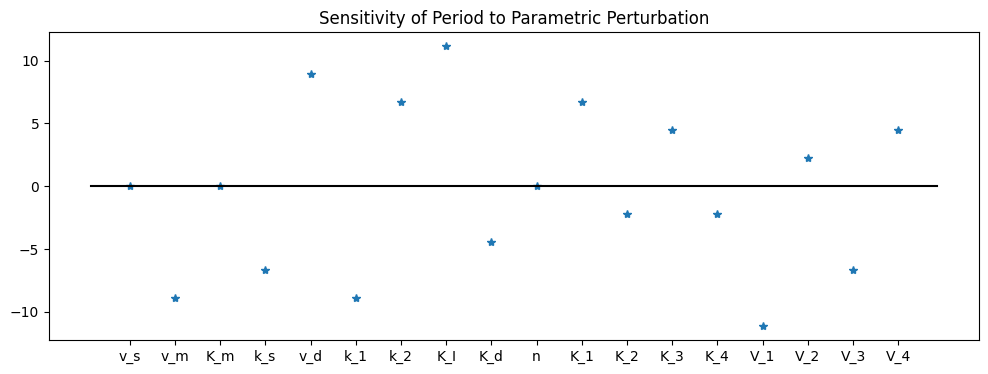

In [7]:
# Testing the sensitivity function
srel_test = sensitivity(gol95_period, np.array(gol_95_params), 0.05)
plt.figure(figsize=(12,4))
plt.plot( np.arange(len(gol_95_params)), srel_test, '*')
plt.plot( plt.xlim(), [0, 0], 'k');
plt.xticks( ticks=np.arange(len(gol_95_params)), labels=gol_95_param_names);
plt.title( "Sensitivity of Period to Parametric Perturbation");

  ## Begin your project here
   
  Complete the project (analyzing the sensitivities) here. If you write extensions, add any support code (e.g. a function to compute the sensitivities to the state dynamics) above. Just concentrate main code for the report here.

### Analysis Setup:

To start Lets look at what the elite parameter sets are that will be used for the analysis.
The rows are the parameter sets and the columns are the parameters.

In [11]:
elite_params = pd.DataFrame(np.array([run[0] for run in Ga_Results]), columns=gol_95_param_names)
elite_params

,v_s,v_m,K_m,k_s,v_d,k_1,k_2,K_I,K_d,n,K_1,K_2,K_3,K_4,V_1,V_2,V_3,V_4
0,0.847321,0.703334,0.793092,1.000000,0.614249,0.562804,0.172443,1.0,0.121466,4.0,1.476416,1.614738,0.948392,1.085652,2.811438,1.518651,2.766402,2.673799
1,0.507998,0.342859,0.180217,0.735766,0.710541,0.919372,0.425408,1.0,0.945827,4.0,0.792406,0.914411,1.786411,1.350938,4.190578,2.897412,1.538757,1.225013
2,0.819794,0.661402,0.333050,0.391630,0.613675,1.735160,0.622451,1.0,0.261753,4.0,1.507712,1.145698,1.541735,0.517729,3.570513,1.548544,2.828342,1.760178
3,0.884003,0.461592,0.692643,0.766230,0.633806,1.866466,1.279748,1.0,0.314719,4.0,2.384164,0.850488,1.738714,0.887139,4.960848,1.353184,2.609873,0.788683
4,0.707123,0.396364,0.305131,0.281592,0.644466,1.698771,0.677039,1.0,0.704066,4.0,0.994117,2.426777,1.207552,1.938229,3.926122,1.143578,1.606133,1.299678
5,0.346700,0.352014,0.465455,0.886955,0.820052,0.887448,1.051420,1.0,0.924604,4.0,2.134811,1.971710,0.730471,2.296218,2.822560,3.888814,2.635125,1.850439
6,0.835177,0.563796,0.942818,0.884507,0.614348,1.233098,0.487628,1.0,0.139198,4.0,0.901773,2.414357,0.613941,2.162020,4.415678,1.786203,1.465790,1.435779
7,0.839400,0.475040,0.259871,0.380179,0.564430,1.646871,0.983711,1.0,0.535321,4.0,1.891411,0.794120,0.949939,2.372161,3.960253,2.772478,2.576320,2.453804
8,0.758030,0.516868,0.470473,0.813288,0.987060,0.500661,0.649725,1.0,0.556168,4.0,0.987464,2.319124,1.800447,2.283408,3.001429,1.616401,4.440630,2.660888
9,0.473405,0.206300,0.118086,0.325555,0.424745,1.863801,0.592557,1.0,0.770087,4.0,1.392076,1.962646,1.065439,1.872864,4.018549,2.225621,1.752582,0.668584


#### 1. Sensitivity analysis of the period

<hr style="border:2px solid gray"> </hr>

Acknowledgements

*Replace this text with links to external resources and thanks to people you worked with.*